# EDA

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pandas as pd

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules import dataloading as dl
from modules import Viz

import matplotlib.pyplot as plt
import seaborn as sns

targetdir = "../data/extracted/"
figtargetdir = "../images/"

## Liquid net worth generally

This section aims to show the distribution of liquid net worth generally. 

In [2]:
df = pd.read_stata('../data/extracted/scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df)
df.head()

,imputed_hh_id,weighting,persons_in_PEU,spouse_part_of_PEU,ref_next_relative_type,switch_of_resp_ref,ref_age,spouse_age,ref_sex,spouse_sex,...,checking_accts_value,savings_accts_value,lqd_assets,educ_bins,doctorate_deg,master_deg,bachelor_deg,assoc_deg,hs_deg,1k_target
household_id,,,,,,,,,,,,,,,,,,,,,
1,13.0,26036.854458,1.0,1.0,0.0,5.0,75.0,0.0,2.0,0.0,...,6000.0,0.0,550000.0,3,0,0,1,0,0,1
2,23.0,18969.956098,5.0,2.0,1.0,1.0,50.0,39.0,1.0,2.0,...,759.0,8.0,767.0,1,1,0,0,0,0,0
3,33.0,20483.071126,2.0,2.0,1.0,1.0,53.0,49.0,1.0,2.0,...,3750.0,0.0,6750.0,1,1,0,0,0,0,1
4,43.0,31785.437408,2.0,2.0,2.0,5.0,29.0,28.0,1.0,2.0,...,3500.0,10006.0,21506.0,4,0,0,0,1,0,1
5,53.0,21046.096210,2.0,2.0,2.0,5.0,47.0,39.0,1.0,2.0,...,-1.0,0.0,-1.0,1,1,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5777 entries, 1 to 5813
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   imputed_hh_id           5777 non-null   float64
 1   weighting               5777 non-null   float64
 2   persons_in_PEU          5777 non-null   float64
 3   spouse_part_of_PEU      5777 non-null   float64
 4   ref_next_relative_type  5777 non-null   float64
 5   switch_of_resp_ref      5777 non-null   float64
 6   ref_age                 5777 non-null   float64
 7   spouse_age              5777 non-null   float64
 8   ref_sex                 5777 non-null   float64
 9   spouse_sex              5777 non-null   float64
 10  ref_race                5777 non-null   float64
 11  spouse_race             5777 non-null   float64
 12  ref_educ                5777 non-null   float64
 13  spouse_educ             5777 non-null   float64
 14  ref_UE_last_year        5777 non-null   

In [4]:
df.lqd_assets.describe()

count    5.777000e+03
mean     2.086218e+06
std      1.512738e+07
min     -2.000000e+00
25%      1.918000e+03
50%      1.500000e+04
75%      1.250320e+05
max      4.727030e+08
Name: lqd_assets, dtype: float64

## Liquid Assets Viz

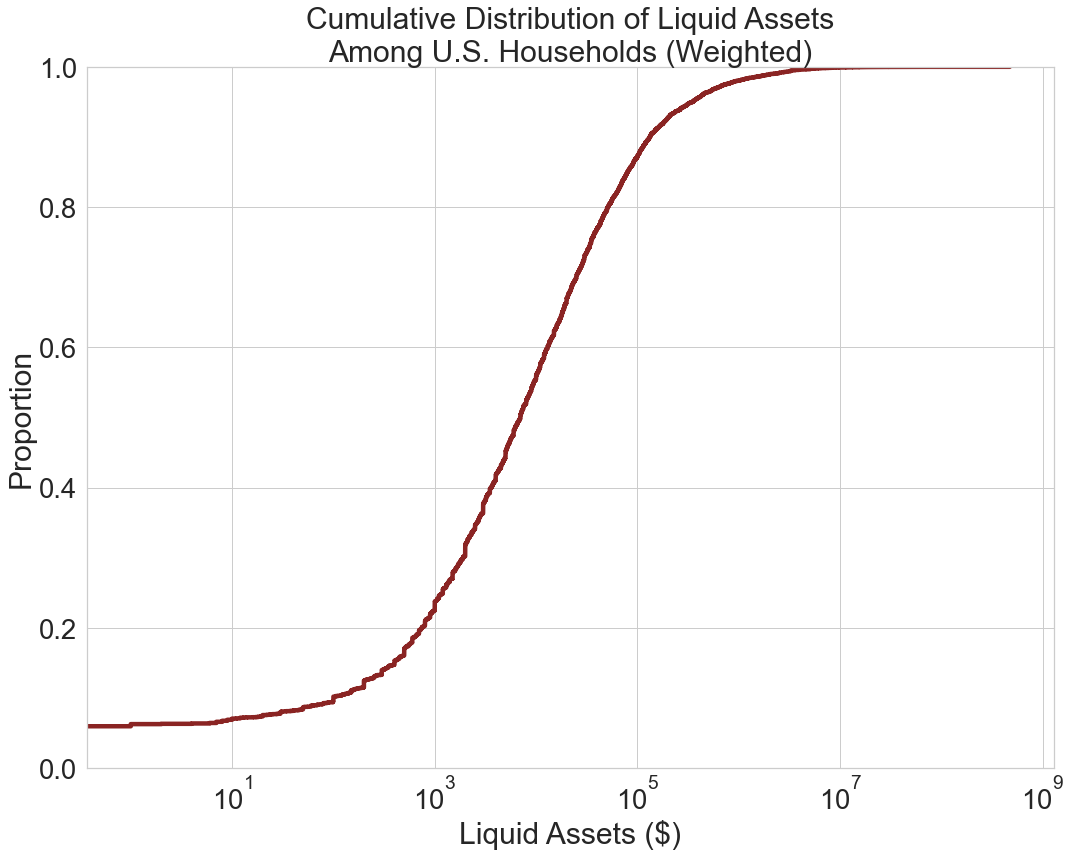

In [5]:
Viz.lqdassetsViz(df, figtargetdir, stat="proportion", weighted=True)

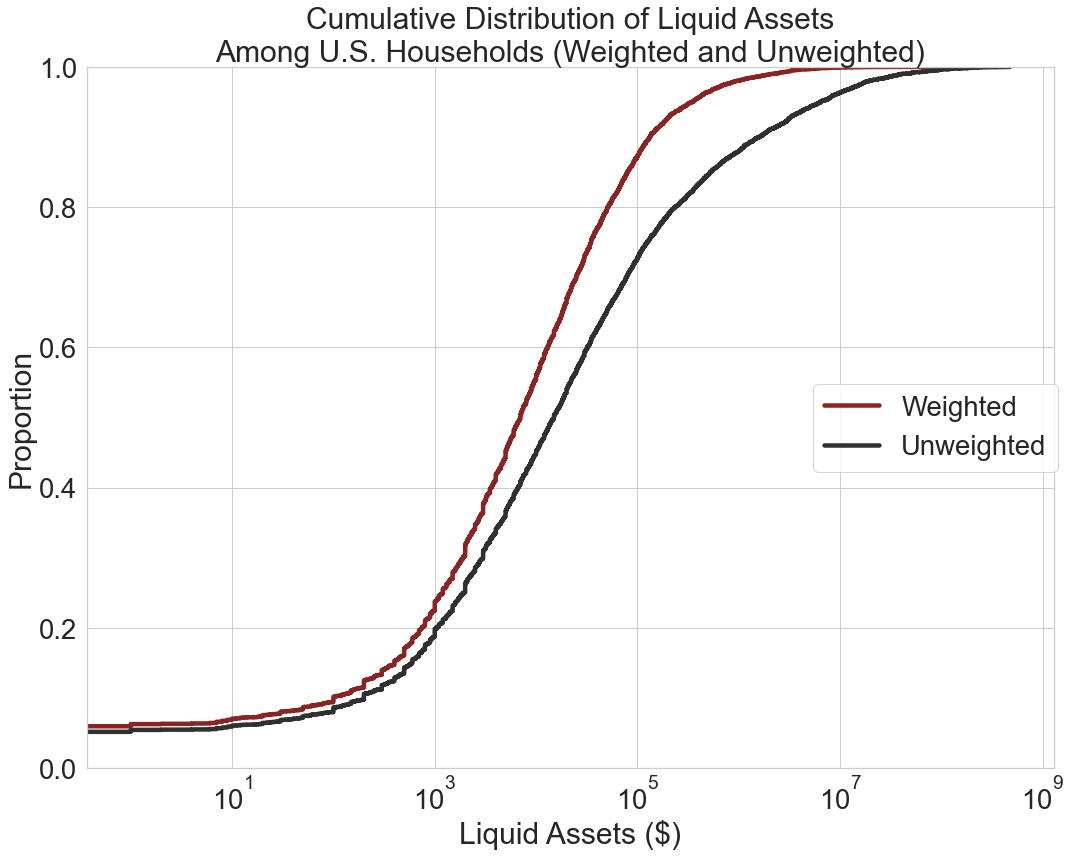

In [6]:
Viz.lqdassetsViz(df, figtargetdir, stat = "proportion", weighted=True, both=True)

## Target var

### Counts

In [7]:
# Unweighted
df['1k_target'].value_counts()

1    4638
0    1139
Name: 1k_target, dtype: int64

In [8]:
# Weighted
df.groupby('1k_target').weighting.sum()

1k_target
0    3.035921e+07
1    9.828322e+07
Name: weighting, dtype: float64

In [9]:
# Multipliers
zero_target = df.groupby('1k_target').weighting.sum()[0]/df['1k_target'].value_counts()[0]
zero_target_str = '{:,.2f}'.format(zero_target)
print(f'Multiplier for target values of zero: {zero_target_str}')

one_target = df.groupby('1k_target').weighting.sum()[1]/df['1k_target'].value_counts()[1]
one_target_str = '{:,.2f}'.format(one_target)
print(f'Multiplier for target values of one: {one_target_str}')

Multiplier for target values of zero: 26,654.26
Multiplier for target values of one: 21,190.86


### Breakdown of lqd_assets

In [10]:
df.lqd_assets.describe()

count    5.777000e+03
mean     2.086218e+06
std      1.512738e+07
min     -2.000000e+00
25%      1.918000e+03
50%      1.500000e+04
75%      1.250320e+05
max      4.727030e+08
Name: lqd_assets, dtype: float64

In [11]:
# Total amount of liquid assets outside of target
tot_nontarget = df.groupby('1k_target').lqd_assets.sum()[0] #9.42 bn weighted
tot_nontarget_str = '{:,.2f}'.format(tot_nontarget)
print(tot_nontarget_str)

353,312.00


In [12]:
# Total amount of liquid assets within target
tot_target = df.groupby('1k_target').lqd_assets.sum()[1] #255 tn weighted
tot_target_str = tot_nontarget_str = '{:,.2f}'.format(tot_target)
print(tot_target_str)

12,051,727,613.00


In [13]:
df.lqd_assets.quantile(.95)

6436880.799999995

### Age

In [14]:
df.ref_age.describe()

count    5777.000000
mean       53.219837
std        16.244778
min        18.000000
25%        40.000000
50%        54.000000
75%        65.000000
max        95.000000
Name: ref_age, dtype: float64

In [15]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

df['age_bins'] = pd.cut(x=df['ref_age'], bins=[17, 29, 45, 59, 75, 95])

In [16]:

df['age_bins'].value_counts()

(59, 75]    1724
(45, 59]    1655
(29, 45]    1422
(17, 29]     499
(75, 95]     477
Name: age_bins, dtype: int64

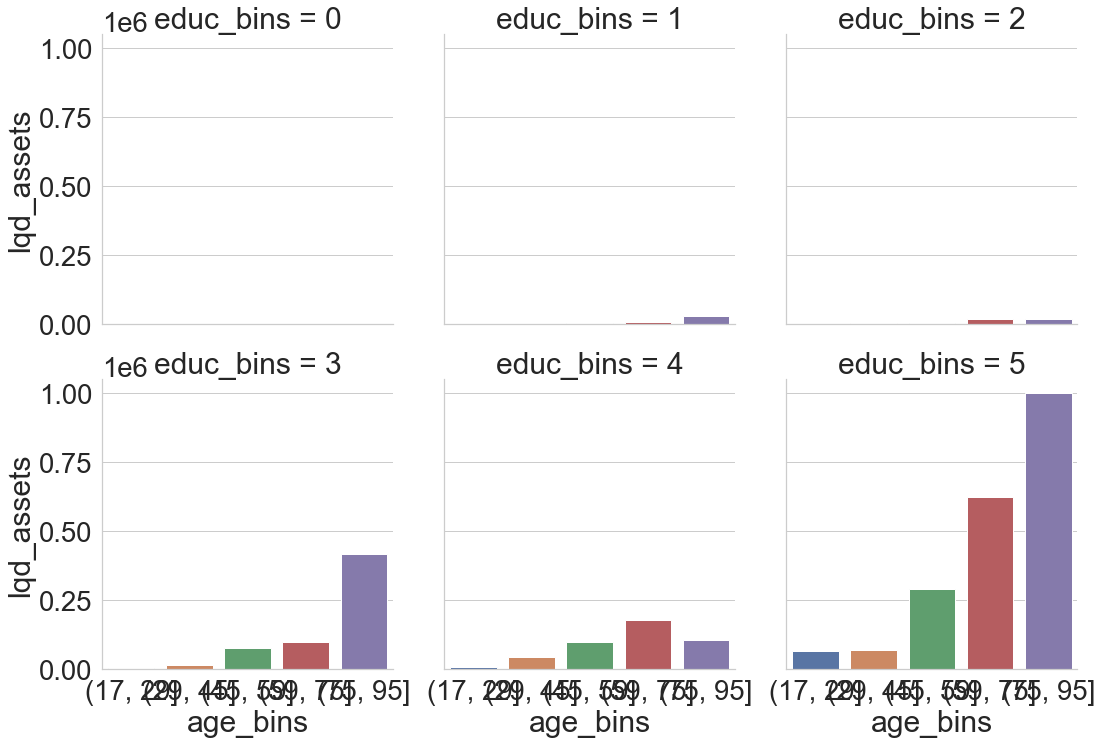

In [17]:
sns.catplot(x="age_bins",
            y='lqd_assets',
            col="educ_bins", 
            col_wrap=3,
            data=df,
            kind='bar',
            ci=None,
            estimator=np.median
           )

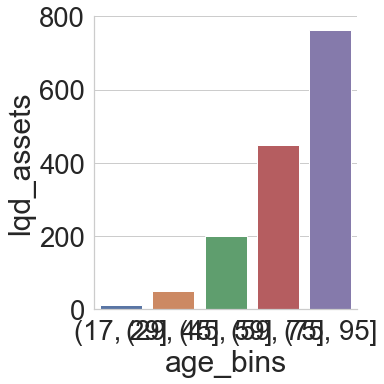

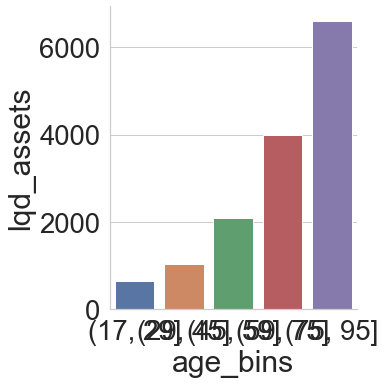

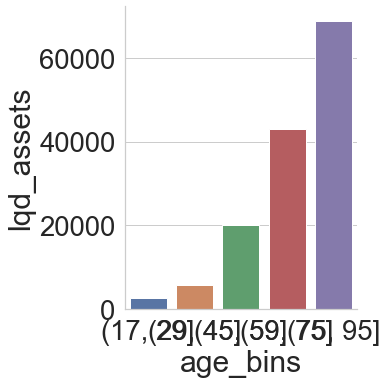

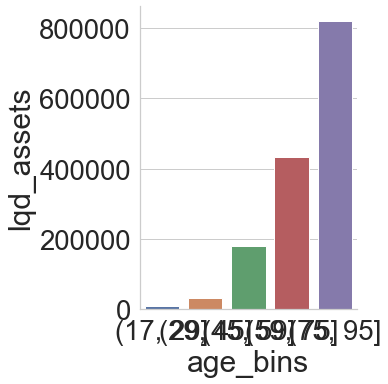

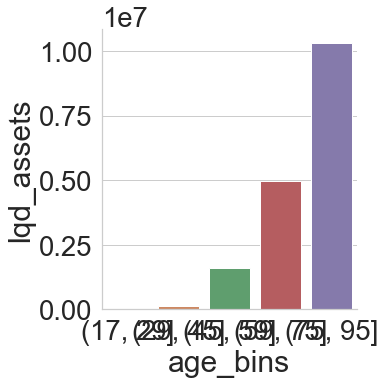

In [18]:

def make_f(i):
    def my_func(x, q=i, **kws):
        quant = np.quantile(x, q)
        return quant
    return my_func

func_dict = {}   
for q in [.1, .25, .5, .75, .9]:
    func_dict[q] = make_f(q)
    
    
for i in func_dict:
    sns.catplot(x="age_bins",
                y='lqd_assets',
                data=df,
                kind='bar',
                estimator=func_dict[i],
                ci=None
               )

## Checking and cleaning cat vars

In [36]:
df = pd.read_stata('../data/extracted/scf2019s/p19i6.dta', columns=dl.sel_vars)
df.columns = [x.lower() for x in df.columns]
df.rename(columns=dl.rename_dict, inplace=True)
df = dl.clean_SCF_df(df, neg_vals=True)


# Variables with negative values
negs_dict = {'dfs': {}, 'value_counts': {}}
for col in df:
    if df[col].min() < 0:
        negs_dict['dfs'][col] = df[df[col] < 0]
        negs_dict['value_counts'][col] = df[df[col] < 0][col].value_counts()
        
negs_dict.keys()
    

dict_keys(['dfs', 'value_counts'])

These are all of the variables that seem to have negative values, which should not be the case. Investigating case-by-case below.

### `ref_race`

In [37]:
var = 'ref_race'
negs_dict['value_counts'][var]

-7.0    324
-0.6      7
-2.2      1
-0.4      1
-1.8      1
-2.0      1
Name: ref_race, dtype: int64

In [21]:
df[df[var] == -7.0].index

Int64Index([  20,   25,   33,   59,   69,   78,   97,  151,  168,  171,
            ...
            5615, 5631, 5643, 5654, 5683, 5715, 5737, 5755, 5778, 5811],
           dtype='int64', name='household_id', length=324)

In [22]:
og_df = pd.read_stata('../data/extracted/scf2019s/p19i6.dta', columns=dl.sel_vars)
og_df.columns = [x.lower() for x in og_df.columns]
og_df.rename(columns=dl.rename_dict, inplace=True)
og_df.head()

,household_id,imputed_hh_id,weighting,persons_in_PEU,spouse_part_of_PEU,ref_next_relative_type,switch_of_resp_ref,ref_age,spouse_age,ref_sex,...,x3748,x3754,x3760,x3765,x3732,x3738,x3744,x3750,x3756,x3762
0,1,11,30598.896539,1,1,0,5,75,0,2,...,0,0,0,0,0,0,0,0,0,0
1,1,12,23561.874562,1,1,0,5,75,0,2,...,0,0,0,0,0,0,0,0,0,0
2,1,13,25726.122276,1,1,0,5,75,0,2,...,0,0,0,0,0,0,0,0,0,0
3,1,14,26488.317060,1,1,0,5,75,0,2,...,0,0,0,0,0,0,0,0,0,0
4,1,15,23809.061856,1,1,0,5,75,0,2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
og_df[og_df.household_id == 20][var]

95   -7
96   -7
97   -7
98   -7
99   -7
Name: ref_race, dtype: int8

-7 means other, so all of these households can go to 0. 


In [24]:
df[df[var] == -0.6].index

Int64Index([226, 233, 669, 2176, 2286, 3617, 3903], dtype='int64', name='household_id')

In [25]:
og_df[og_df.household_id == 226][var]

1120    1
1121   -7
1122    1
1123    1
1124    1
Name: ref_race, dtype: int8

In [26]:
og_df[og_df.household_id == 233][var]

1155    1
1156    1
1157    1
1158    1
1159   -7
Name: ref_race, dtype: int8

For some reason the imputed dataset also seems to impute race to other in some cases. Anything that is not -7 for race may have to go to 1.

In [27]:
df[df[var] == -1.8].index

Int64Index([46], dtype='int64', name='household_id')

In [28]:
og_df[og_df.household_id == 46][var]

225   -7
226    2
227    1
228   -7
229    2
Name: ref_race, dtype: int8

I think given the mixture of races in the imputed data for each HH and their relatively low number, all of these will go to 0.

### `ref_educ`

In [29]:
var = 'ref_educ'
negs_dict['value_counts'][var]

-1.0    9
Name: ref_educ, dtype: int64

-1 means less than first grade so these will go to 0.

### `spouse_educ`

In [30]:
var = 'spouse_educ'
negs_dict['value_counts'][var]

-1.0    6
Name: spouse_educ, dtype: int64

Same as `ref_educ`

### `total_income`

In [31]:
var = 'total_income'
negs_dict['value_counts'][var]

-9.0    36
-1.0     9
Name: total_income, dtype: int64

-1 is nothing and -9 is negative income generally, so all of these will go to 0. 

### `life_ins_cash_value`

In [32]:
var = 'life_ins_cash_value'
negs_dict['value_counts'][var]

-1.0    42
Name: life_ins_cash_value, dtype: int64

-1 is also nothing, so goes to 0. This is getting tedious. I've adjusted the dict.

In [33]:
negs_dict['value_counts']

{'ref_race': -7.0    324
 -0.6      7
 -2.2      1
 -0.4      1
 -1.8      1
 -2.0      1
 Name: ref_race, dtype: int64, 'ref_educ': -1.0    9
 Name: ref_educ, dtype: int64, 'spouse_educ': -1.0    6
 Name: spouse_educ, dtype: int64, 'total_income': -9.0    36
 -1.0     9
 Name: total_income, dtype: int64, 'life_ins_cash_value': -1.0    42
 Name: life_ins_cash_value, dtype: int64, 'total_cc_limit': -1.0    12
 Name: total_cc_limit, dtype: int64, 'num_fin_inst': -1.0    136
 -0.6      1
 Name: num_fin_inst, dtype: int64, 'cc_newcharges_value': -1.0    290
 -2.0    169
 -3.0      8
 Name: cc_newcharges_value, dtype: int64, 'cc_currbal_value': -2.0    1219
 -1.0    1071
 -3.0     259
 -1.6       1
 -2.2       1
 -2.8       1
 -2.6       1
 -2.4       1
 Name: cc_currbal_value, dtype: int64, 'checking_accts_value': -1.0    53
 -2.0     5
 Name: checking_accts_value, dtype: int64, 'savings_accts_value': -1.0    8
 -2.0    3
 -5.0    1
 Name: savings_accts_value, dtype: int64, 'lqd_assets': -